### Problem Description

Write some details about the problem

In [107]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))


## Packages

In [108]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(font_scale=1.3)
import time

from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import scipy
from sklearn.linear_model import Ridge

### Read Dataset

In [109]:
df = pd.read_csv("Online Retail.csv", encoding="ISO-8859-1", dtype={'CustomerID': str}, parse_dates=['InvoiceDate'])
df.shape

(541909, 8)

In [110]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


## EDA

In [111]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [112]:
# Cheching for missing data
missing_percentage = (df.isna().sum() /df.shape[0])*100
missing_percentage

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

In [113]:
# Removing None Customer IDs ... save clean dataframe with same variable `df`
df.dropna(inplace=True)

In [114]:
# Just for Checking 
df.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

### Q1: Which Country makes the most transactions?

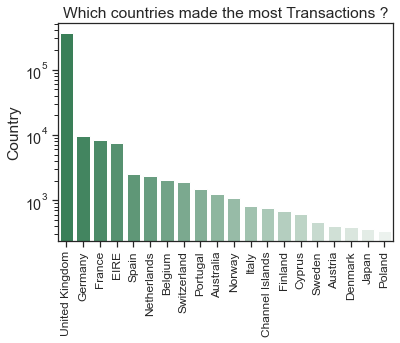

<Figure size 1296x360 with 0 Axes>

In [115]:
sns.set_style('ticks')

data =df.Country.value_counts()[:20]

#pal = sns.color_palette(palette="Greens_d", n_colors=len(data))
pal = sns.light_palette("seagreen",n_colors=len(data))
sns.barplot(x=data.index, y=data, palette=np.array(pal[::-1]))

plt.title('Which countries made the most Transactions ?')
plt.xticks(size=12, rotation=90)
plt.yscale('log')
plt.figure(figsize=(18,5));
plt.show()

### Q2: Show the Top 10 Customers how made the largest Revenue

#### Q6: Calculate the Total Revenue for each Row

In [116]:
df['Revenue'] = df['Quantity']*df['UnitPrice']
df_top_10 =df.groupby(['CustomerID'] ,as_index=False)['Revenue'].sum().sort_values(['Revenue'],ascending=False)
df_top_10.head(10)

,CustomerID,Revenue
1703,14646,279489.02
4233,18102,256438.49
3758,17450,187482.17
1895,14911,132572.62
55,12415,123725.45
1345,14156,113384.14
3801,17511,88125.38
3202,16684,65892.08
1005,13694,62653.10
2192,15311,59419.34


### Q3: Show Top 5 frequent Customers

In [117]:
#df_top_cust=df.pddf.CustomerID.value_counts().values
df_top_cust = df.CustomerID.value_counts().rename_axis('CustomerID').reset_index(name='Frequency')
df_top_cust.head(5)

,CustomerID,Frequency
0,17841,7983
1,14911,5903
2,14096,5128
3,12748,4642
4,14606,2782


In [118]:
f"{df.shape[0]:,}"

'406,829'

### Q4: Create a histogram that reveals the count of words of 𝑫𝒆𝒔𝒄𝒓𝒊𝒑𝒕𝒊𝒐𝒏

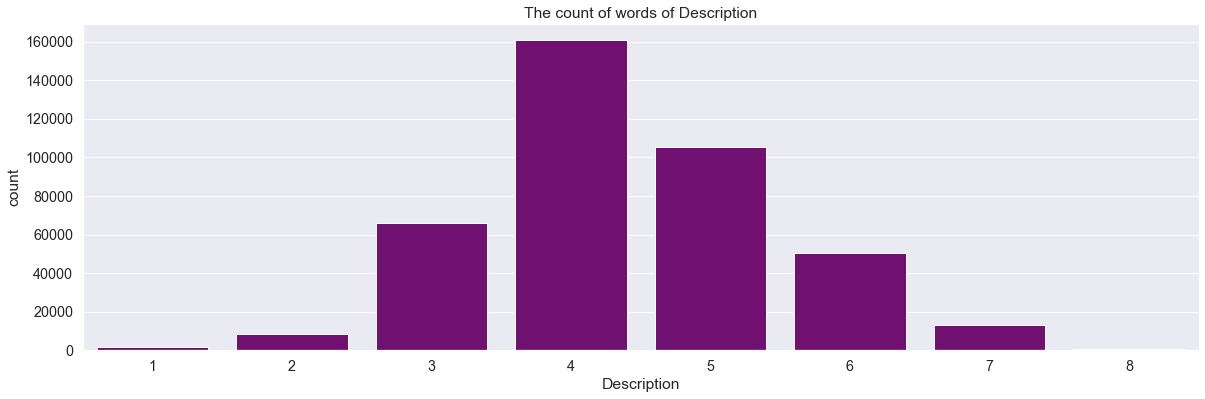

In [119]:
sns.set_style('darkgrid')
plt.figure(figsize=(20,6));
data =df.Description.str.split().apply(len).value_counts()

sns.barplot(x=data.index, y=data ,color="purple")
plt.title("The count of words of Description")
plt.xlabel('Description')
plt.ylabel('count')

plt.show()
#sns.dark_palette("purple")

####  Create a histogram that reveals the count of letters of 𝑫𝒆𝒔𝒄𝒓𝒊𝒑𝒕𝒊𝒐𝒏

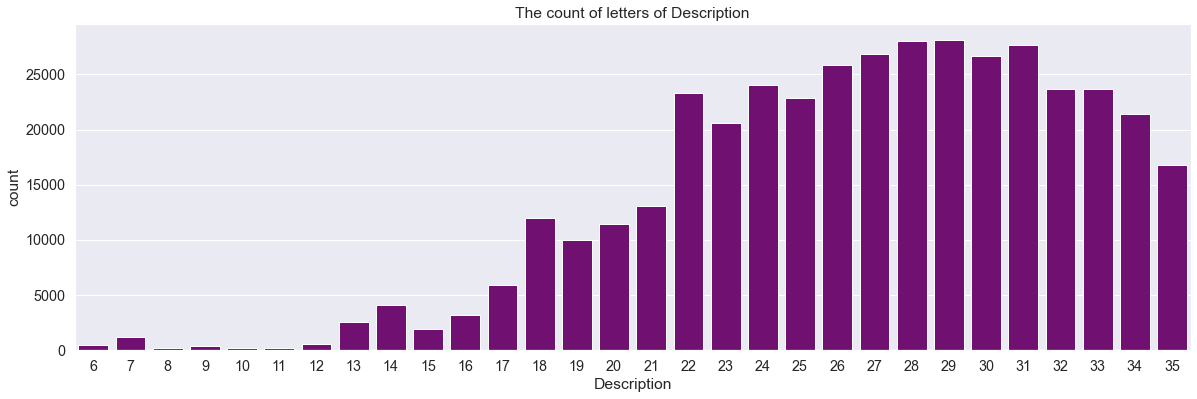

In [120]:
sns.set_style('darkgrid')
plt.figure(figsize=(20,6));
data =df.Description.apply(len).value_counts()

sns.barplot(x=data.index, y=data ,color="purple")
plt.title("The count of letters of Description")
plt.xlabel('Description')
plt.ylabel('count')

plt.show()


### Q5: Extract {𝑌𝑒𝑎𝑟, 𝑀𝑜𝑛𝑡ℎ, 𝑊𝑒𝑒𝑘, 𝑊𝑒𝑒𝑘𝐷𝑎𝑦, 𝐷𝑎𝑦, 𝐷𝑎𝑦𝑂𝑓𝑌𝑒𝑎𝑟,𝐷𝑎𝑡𝑒} features from 𝐼𝑛𝑣𝑜𝑖𝑐𝑒𝐷𝑎𝑡𝑒 feature
P.S: Date is based on Year, Month & Day features

In [121]:
df.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


In [122]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df["Year"] =df['InvoiceDate'].dt.year 
df["Quarter"] =df['InvoiceDate'].dt.quarter 
df["Month"] =df['InvoiceDate'].dt.month 
df["Week"] = df['InvoiceDate'].dt.week
df["Weekday"] = df['InvoiceDate'].dt.dayofweek
df["Day"] = df['InvoiceDate'].dt.day
df["Dayofyear"] = df['InvoiceDate'].dt.dayofyear
df["Date"] = df['InvoiceDate'].dt.date

<ipython-input-122-f9109fe5614b>:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df["Week"] = df['InvoiceDate'].dt.week


In [123]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,Year,Quarter,Month,Week,Weekday,Day,Dayofyear,Date
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010,4,12,48,2,1,335,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,4,12,48,2,1,335,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010,4,12,48,2,1,335,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,4,12,48,2,1,335,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,4,12,48,2,1,335,2010-12-01


### Q7 & Q8: Aggregate Revenue & Quantity across the grouped_features

In [131]:
df.head(1)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,Year,Quarter,Month,Week,Weekday,Day,Dayofyear,Date
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.3,2010,4,12,48,2,1,335,2010-12-01


In [162]:
grouped_features = ['Date','Year','Quarter','Month','Dayofyear','Day','StockCode']
df.groupby(grouped_features,as_index=False)[['Quantity','Revenue']].sum().head()


,Date,Year,Quarter,Month,Dayofyear,Day,StockCode,Quantity,Revenue
0,2010-12-01,2010,4,12,335,1,10002,60,51.00
1,2010-12-01,2010,4,12,335,1,10125,2,1.70
2,2010-12-01,2010,4,12,335,1,10133,5,4.25
3,2010-12-01,2010,4,12,335,1,15044B,1,2.95
4,2010-12-01,2010,4,12,335,1,15056BL,20,113.00


## (Optional Part)
#### You Can go on with the Modelling part using any type of 
  - ML model 
  - features pre-processing 
  - Loss function

as mentioned in the Questions

### Modelling

Regression model to predict Revenue based on revenue in past months

In [163]:
df_new = df.groupby(['Month'],as_index=False)[['Quantity','Revenue']].sum()
df_new.head()

,Month,Quantity,Revenue
0,1,269379,475074.380
1,2,262833,436546.150
2,3,344012,579964.610
3,4,278585,426047.851
4,5,367852,648251.080


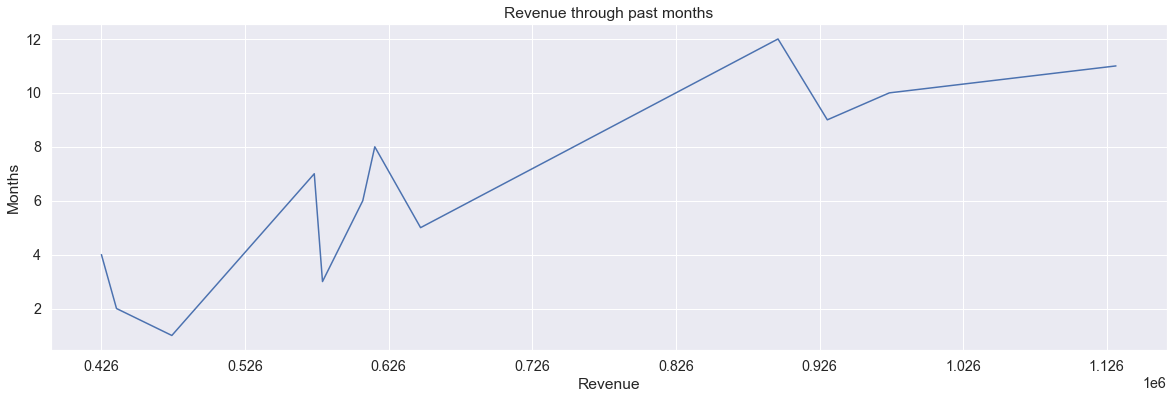

In [196]:
x= np.array(df_new.Revenue)
y =np.array(df_new.Month)
plt.figure(figsize=(20,6));
plt.xticks(np.arange(df_new.Revenue.min(), df_new.Revenue.max(),1e5))
sns.lineplot(x=x,y=y);
plt.title('Revenue through past months');
plt.xlabel("Revenue");
plt.ylabel("Months");

In [165]:
import numpy as np
from sklearn.linear_model import LinearRegression

df_new = df.groupby(['Month'],as_index=False)[['Quantity','Revenue']].sum()
x= np.array(df_new.Revenue).reshape((-1, 1))
y =np.array(df_new.Month)
model = LinearRegression()
model.fit(x,y)
r_sq = model.score(x, y)
print('coefficient of determination:', r_sq)

coefficient of determination: 0.7553120106024109


In [201]:
x_new = np.arange(1,5).reshape((-1, 1))
print(x_new)

y_new = model.predict(x_new)
print(y_new)

[[1]
 [2]
 [3]
 [4]]
[-2.80051451 -2.80050106 -2.80048762 -2.80047417]


# Great Job
### Now go through the Food Review Notebook